## Imports

In [1]:
# ─────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────
# Imports
# Standard Library
import os
import logging
import warnings
import collections
from typing import TYPE_CHECKING, Callable, Iterable, Literal

# ─────────────────────────────────────────────────────────────
# Scientific Python Libraries
import numpy as np
import pandas as pd

# ─────────────────────────────────────────────────────────────
# PyTorch Core 
import torch
from torch.distributions import Distribution
import torch.nn.functional as F
from torch import nn
from torch.nn import ModuleList
from torch.nn.functional import one_hot
from torch.distributions import Normal

# ─────────────────────────────────────────────────────────────
# Single-cell analysis tools
import anndata
import scanpy as sc
from anndata import AnnData

# ─────────────────────────────────────────────────────────────
# scvi-tools Core
import scvi
from scvi import REGISTRY_KEYS, settings
from scvi.data import AnnDataManager
from scvi.data._constants import ADATA_MINIFY_TYPE
from scvi.data._utils import _get_adata_minify_type
from scvi.data.fields import (
    CategoricalObsField,
    CategoricalJointObsField,
    NumericalObsField,
    NumericalJointObsField,
    LayerField,
)

# ─────────────────────────────────────────────────────────────
# cvi-tools Models & Modules
from scvi.model._utils import _init_library_size
from scvi.model.base import (
    EmbeddingMixin,
    UnsupervisedTrainingMixin,
    ArchesMixin,
    BaseMinifiedModeModelClass,
    RNASeqMixin,
    VAEMixin,
)

from scvi.module._constants import MODULE_KEYS
from scvi.module.base import (
    BaseMinifiedModeModuleClass,
    EmbeddingModuleMixin,
    LossOutput,
    auto_move_data,
)

from scvi.nn import Encoder
from scvi.nn import FCLayers
from scvi.nn._utils import ExpActivation
from scvi.utils import (
    unsupported_if_adata_minified,
    setup_anndata_dsp,
)

# ─────────────────────────────────────────────────────────────
# Type Hints (not executed)
if TYPE_CHECKING:
    from torch.distributions import Distribution
    from anndata import AnnData

# ─────────────────────────────────────────────────────────────
# Helpers
def _identity(x):
    return x

# Logger setup
logger = logging.getLogger(__name__)


# ─────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


## Decoder

In [2]:
# Classes
class DecoderCCVI(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        n_cell_types: int,
        n_layers: int = 1,
        n_hidden: int = 128,
        n_cat_list: Iterable[int] = None,
        inject_covariates: bool = False,
        use_batch_norm: bool = False,
        use_layer_norm: bool = False,
        scale_activation: Literal["softmax", "softplus"] = "softmax",
        cycle_gene_mask: torch.Tensor | None = None,
        **kwargs
    ):
        super().__init__()

        if cycle_gene_mask is None:
            raise ValueError("`cycle_gene_mask` must be provided")
        if cycle_gene_mask.shape[0] != n_output:
            raise ValueError("`cycle_gene_mask` must match number of output genes")
        self.register_buffer("cycle_mask", cycle_gene_mask.float())

        self.n_output = n_output

        # z -> [cosθ, sinθ]
        self.phase_decoder = FCLayers(
            n_in=n_input,
            n_out=3,
            n_cont=0,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=False,
            use_batch_norm=use_batch_norm,
            use_layer_norm=use_layer_norm,
            **kwargs
        )

        # z + d -> response scalar
        self.drug_response_decoder = FCLayers(
            n_in=n_input,
            n_out=1,
            n_cont=1,
            n_hidden=n_hidden,
            n_layers=n_layers,
            inject_covariates=True,
            use_batch_norm=False,
            use_layer_norm=False,
            **kwargs
        )

        # Learnable parameters
        self.W_phase = nn.Parameter(torch.randn(3, n_output))  # [3 phases, G genes]
        self.W_drug = nn.Parameter(torch.randn(n_output))    # [G]
        self.b_type = nn.Parameter(torch.randn(n_cell_types, n_output))     # [T, G]
        self.theta_type = nn.Parameter(torch.randn(n_cell_types, n_output)) # [T, G]

        if scale_activation == "softmax":
            self.px_scale_activation = nn.Softmax(dim=-1)
        elif scale_activation == "softplus":
            self.px_scale_activation = nn.Softplus()
        else:
            raise ValueError(f"Unknown scale_activation: {scale_activation}")

    def forward(
        self,
        z: torch.Tensor,
        library: torch.Tensor,
        d: torch.Tensor,
        t: torch.Tensor
    ):
        assert d.ndim == 2 and d.size(1) == 1, "Drug covariate d must be shape [N, 1]"
        assert t.ndim == 1, "Cell type t must be 1D [N]"

        control_mask = (d.squeeze() == 0)  # [N]

        # --- Cell cycle effect ---
        phase_logits = self.phase_decoder(z)                    
        phase_probs = F.softmax(phase_logits, dim=1)              
        cycle_effect = torch.matmul(phase_probs, self.W_phase * self.cycle_mask)  

        # --- Drug response ---
        raw_r = self.drug_response_decoder(z, cont=d).squeeze(-1)  # [N]
        r = F.softplus(raw_r)  # Ensure r >= 0
        r = torch.where(control_mask, torch.zeros_like(r), r)  # r = 0 for control cells

        # --- Baseline and dispersion ---
        b_t = self.b_type[t]        # [N, G]
        theta = self.theta_type[t] # [N, G]

        b_t = torch.where(control_mask.unsqueeze(1), b_t, b_t.detach())
        theta = torch.where(control_mask.unsqueeze(1), theta, theta.detach())

        drug_effect = r.unsqueeze(-1) * self.W_drug  # [N, G]

        eta = b_t + cycle_effect + drug_effect  # [N, G]

        # --- Output ---
        px_scale = self.px_scale_activation(eta)  # [N, G]
        px_rate = torch.exp(library) * px_scale   # [N, G]

        return (
            px_scale,           # scaled expression (normalized or positive)
            theta,              # dispersion (may be partially detached)
            px_rate,            # mean for NB
            None,               # placeholder
            phase_probs,         
            r,                  # drug response scalar
            None,               # placeholder
            self.W_phase,       # cycle weights
            self.W_drug,        # drug weights
            self.b_type         # baseline parameters
        )

## VAE

In [3]:
class CC_VAE(
# 1. CLASS INHERITANCE
    EmbeddingModuleMixin, BaseMinifiedModeModuleClass):
# 2. ClASS DOCSTRING
    """
    Variational auto-encoder.

    This class implements a variational autoencoder (VAE) for single-cell RNA-seq data.
    It inherits from an embedding mixin (for latent representations) and a base module class
    that supports minified AnnData mode.
    
    Parameters
    ----------
    n_input
        Number of input features.
    n_batch
        Number of batches. If ``0``, no batch correction is performed.
    n_labels
        Number of labels.
    n_hidden
        Number of nodes per hidden layer. Passed into Encoder and DecoderSCVI.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers. Passed into Encoder and DecoderSCVI.
    n_continuous_cov
        Number of continuous covariates.
    n_cats_per_cov
        A list of integers containing the number of categories for each categorical covariate.
    dropout_rate
        Dropout rate, passed into the Encoder.
    dispersion
        Parameter controlling dispersion for the likelihood distribution.
    log_variational
        Whether to apply log1p to input data for numerical stability.
    gene_likelihood
        Likelihood distribution for gene expression (e.g. "zinb", "nb", "poisson").
    latent_distribution
        Distribution for the latent space (e.g. "normal", "ln").
    encode_covariates
        Whether to concatenate covariates to the gene expression before encoding.
    deeply_inject_covariates
        If True and n_layers > 1, covariates are injected at each hidden layer.
    batch_representation
        How to represent batch information ("one-hot" or "embedding").
    use_batch_norm
        Where to use Batch Normalization ("none", "encoder", "decoder", "both").
    use_layer_norm
        Where to use Layer Normalization ("none", "encoder", "decoder", "both").
    use_size_factor_key
        If True, use an AnnData.obs column as the scaling factor for the likelihood.
    use_observed_lib_size
        If True, use the observed library size for scaling.
    library_log_means
        Numpy array with means for log library sizes (if not using observed library size).
    library_log_vars
        Numpy array with variances for log library sizes (if not using observed library size).
    var_activation
        Callable for ensuring positivity of the variance output in the encoder.
    extra_encoder_kwargs
        Extra keyword arguments for the Encoder.
    extra_decoder_kwargs
        Extra keyword arguments for the DecoderSCVI.
    batch_embedding_kwargs
        Keyword arguments for the batch embedding layer (if using embedding representation).
    """

# 3. CONSTRUCTOR
    '''
    - Checks and stores all parameters
    - Handles dispersion type (per gene/cell/batch/label)
    - Initializes encoders: 
            z_encoder for latent variables
        latent_distribution: Literal["normal", "ln"] = "normal",
            # Distribution used for latent variables ("normal" or "logistic normal")
        encode_covariates: bool = False,  # Whether to concatenate covariates with gene expression data
        deeply_inject_covariates: bool = True,  # Whether to inject covariates at deeper layers in the encoder/decoder
        batch_representation: Literal["one-hot", "embedding"] = "one-hot",
            # How to represent batch information (one-hot vector or learned embedding)
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
            # Where to apply Batch Normalization in the network
            l_encoder for library size
    - Initializes decoder based on latent space + covariates
    - Handles categorical and continuous covariates'''
    
    def __init__(
        self,
        n_input: int,   # Number of input features (e.g., number of genes)
        n_batch: int = 0,  # Number of batches; 0 implies no batch correction
        n_labels: int = 0,  # Number of labels (if any)
        n_hidden: int = 128,  # Number of nodes in each hidden layer
        n_latent: int = 10,   # Dimensionality of the latent space
        n_layers: int = 1,    # Number of layers in the encoder/decoder networks
        n_continuous_cov: int = 0,  # Number of continuous covariates
        n_cats_per_cov: list[int] | None = None,  # List with number of categories for each categorical covariate
        dropout_rate: float = 0.1,  # Dropout rate for the neural network layers
        dispersion: Literal["gene", "gene-batch", "gene-label", "gene-cell"] = "gene-label",
            # Dispersion model: how variance is modeled (per gene, per batch, etc.)
        log_variational: bool = True,  # Whether to apply log1p on input data for numerical stability
        gene_likelihood: Literal["zinb", "nb", "poisson"] = "nb",
            # Likelihood model for gene expression (Zero-Inflated Negative Binomial, etc.)
        latent_distribution: Literal["normal", "ln"] = "normal",
            # Distribution used for latent variables ("normal" or "logistic normal")
        encode_covariates: bool = False,  # Whether to concatenate covariates with gene expression data
        deeply_inject_covariates: bool = True,  # Whether to inject covariates at deeper layers in the encoder/decoder
        batch_representation: Literal["one-hot", "embedding"] = "one-hot",
            # How to represent batch information (one-hot vector or learned embedding)
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
            # Where to apply Batch Normalization in the network
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "none",
            # Where to apply Layer Normalization in the network
        use_size_factor_key: bool = False,  # Whether to use size factors from AnnData.obs as scaling factors
        use_observed_lib_size: bool = True,  # Whether to use the observed library size directly for scaling
        library_log_means: np.ndarray | None = None,  # Precomputed means of log library sizes (if not observed)
        library_log_vars: np.ndarray | None = None,   # Precomputed variances of log library sizes (if not observed)
        var_activation: Callable[[torch.Tensor], torch.Tensor] = None,  # Activation for variance output (e.g., torch.exp)
        extra_encoder_kwargs: dict | None = None,  # Additional parameters for the Encoder
        extra_decoder_kwargs: dict | None = None,  # Additional parameters for the DecoderSCVI
        batch_embedding_kwargs: dict | None = None,  # Additional parameters for batch embedding layer (if used)
        cycle_gene_mask: torch.Tensor | None = None,
    ):

        super().__init__()  # Initialize parent classes (EmbeddingModuleMixin and BaseMinifiedModeModuleClass)

        # Store various model parameters as attributes
        self.dispersion = dispersion
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.gene_likelihood = gene_likelihood
        self.n_batch = n_batch
        self.n_labels = n_labels
        self.latent_distribution = latent_distribution
        self.encode_covariates = encode_covariates
        self.use_size_factor_key = use_size_factor_key
        # If size factor key is used, then use_observed_lib_size is True; otherwise, use the provided flag
        self.use_observed_lib_size = use_size_factor_key or use_observed_lib_size

        # If not using observed library size, then library_log_means and library_log_vars must be provided
        if not self.use_observed_lib_size:
            if library_log_means is None or library_log_vars is None:
                raise ValueError(
                    "If not using observed_lib_size, must provide library_log_means and library_log_vars."
                )
            # Register these as buffers (non-parameter tensors that move with the model)
            self.register_buffer("library_log_means", torch.from_numpy(library_log_means).float())
            self.register_buffer("library_log_vars", torch.from_numpy(library_log_vars).float())

        # Setup batch representation; if embedding is chosen, initialize an embedding layer
        self.batch_representation = batch_representation
        if self.batch_representation == "embedding":
            # Initialize embedding for batches using a key from REGISTRY_KEYS and extra kwargs if provided
            self.init_embedding(REGISTRY_KEYS.BATCH_KEY, n_batch, **(batch_embedding_kwargs or {}))
            # Get the embedding dimension from the initialized embedding layer
            batch_dim = self.get_embedding(REGISTRY_KEYS.BATCH_KEY).embedding_dim
        elif self.batch_representation != "one-hot":
            raise ValueError("`batch_representation` must be one of 'one-hot', 'embedding'.")

        # Determine where to apply normalization in the encoder and decoder
        use_batch_norm_encoder = use_batch_norm == "encoder" or use_batch_norm == "both"
        use_batch_norm_decoder = use_batch_norm == "decoder" or use_batch_norm == "both"
        use_layer_norm_encoder = use_layer_norm == "encoder" or use_layer_norm == "both"
        use_layer_norm_decoder = use_layer_norm == "decoder" or use_layer_norm == "both"

        # Calculate the input dimension for the encoder. Start with gene counts and add covariates if encoding them.
        n_input_encoder = n_input + n_continuous_cov * encode_covariates
        if self.batch_representation == "embedding":
            n_input_encoder += batch_dim * encode_covariates  # Add batch embedding dimension if applicable
            cat_list = list([] if n_cats_per_cov is None else n_cats_per_cov)
        else:
            # For one-hot, add n_batch as a categorical variable
            cat_list = [n_batch] + list([] if n_cats_per_cov is None else n_cats_per_cov)

        # Only include categorical covariates if requested
        encoder_cat_list = cat_list if encode_covariates else None
        _extra_encoder_kwargs = extra_encoder_kwargs or {}
        # Initialize the encoder for the latent variable "z"
        self.z_encoder = Encoder(
            n_input_encoder,
            n_latent,
            n_cat_list=encoder_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,  # Return a distribution rather than a fixed tensor
            **_extra_encoder_kwargs,
        )

        # Calculate input dimension for the decoder: latent dimension plus continuous covariates
        n_input_decoder = n_latent
        if self.batch_representation == "embedding":
            n_input_decoder += batch_dim  # Add embedding dimension for batch representation

        _extra_decoder_kwargs = extra_decoder_kwargs or {}
        # Initialize the decoder module that maps latent space back to the original input space
        self.decoder = DecoderCCVI(
            n_input=n_input_decoder,
            n_output=n_input,
            n_cell_types=n_labels,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_decoder,
            use_layer_norm=use_layer_norm_decoder,
            scale_activation="softplus" if use_size_factor_key else "softmax",
            cycle_gene_mask=cycle_gene_mask,
            **_extra_decoder_kwargs,
        )
# 4. Prepare tensors for inference 
    def _get_inference_input(
        self,
        tensors: dict[str, torch.Tensor | None],
        full_forward_pass: bool = False,
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the inference process."""
        # Decide which data loader to use based on full_forward_pass flag and the minified data type
        if full_forward_pass or self.minified_data_type is None:
            loader = "full_data"
        elif self.minified_data_type in [
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR,
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR_WITH_COUNTS,
        ]:
            loader = "minified_data"
        else:
            raise NotImplementedError(f"Unknown minified-data type: {self.minified_data_type}")

        # For full data, return the standard tensors used in the model
        if loader == "full_data":
            return {
                MODULE_KEYS.X_KEY: tensors[REGISTRY_KEYS.X_KEY],
                MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
                MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
                MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            }
        else:
            # For minified data, use cached latent parameters
            return {
                MODULE_KEYS.QZM_KEY: tensors[REGISTRY_KEYS.LATENT_QZM_KEY],
                MODULE_KEYS.QZV_KEY: tensors[REGISTRY_KEYS.LATENT_QZV_KEY],
                REGISTRY_KEYS.OBSERVED_LIB_SIZE: tensors[REGISTRY_KEYS.OBSERVED_LIB_SIZE],
            }

# 5. Prepare tensors for generative model  
    def _get_generative_input(
        self,
        tensors: dict[str, torch.Tensor],
        inference_outputs: dict[str, torch.Tensor | Distribution | None],
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the generative process."""
        # Retrieve and transform size factor if provided
        size_factor = tensors.get(REGISTRY_KEYS.SIZE_FACTOR_KEY, None)
        if size_factor is not None:
            size_factor = torch.log(size_factor)

        # Return a dictionary mapping module keys to the appropriate tensors/distributions
        return {
            MODULE_KEYS.Z_KEY: inference_outputs[MODULE_KEYS.Z_KEY],
            MODULE_KEYS.LIBRARY_KEY: inference_outputs[MODULE_KEYS.LIBRARY_KEY],
            MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
            MODULE_KEYS.Y_KEY: tensors[REGISTRY_KEYS.LABELS_KEY],
            MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
            MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            MODULE_KEYS.SIZE_FACTOR_KEY: size_factor,
        }

# 6. For each cell, computes the mean and variance of the log library size for the corresponding batch.
    def _compute_local_library_params(
        self,
        batch_index: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes local library parameters.

        For each cell, computes the mean and variance of the log library size
        for the corresponding batch.
        """
        from torch.nn.functional import linear

        n_batch = self.library_log_means.shape[1]  # Number of batches from the library means buffer
        # Compute local means using one-hot encoding for the batch index and linear transformation
        local_library_log_means = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_means
        )
        # Compute local variances similarly
        local_library_log_vars = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_vars
        )

        return local_library_log_means, local_library_log_vars

    @auto_move_data  # Automatically move inputs/outputs to the correct device (CPU/GPU)

# 7. Encodes input data into latent variables:
    def _regular_inference(
        self,
        x: torch.Tensor,                 # Input gene expression data
        batch_index: torch.Tensor,       # Batch indices for each cell
        cont_covs: torch.Tensor | None = None,  # Continuous covariates (if any)
        cat_covs: torch.Tensor | None = None,   # Categorical covariates (if any)
        n_samples: int = 1,                # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | Distribution | None]:
        """Run the regular inference process."""
        x_ = x  # Make a copy of the input
        # If using observed library size, compute it as the log sum of gene counts
        if self.use_observed_lib_size:
            library = torch.log(x.sum(1)).unsqueeze(1)
        # Apply logarithmic transformation if specified
        if self.log_variational:
            x_ = torch.log1p(x_)

        # Concatenate continuous covariates if they are to be encoded
        if cont_covs is not None and self.encode_covariates:
            encoder_input = torch.cat((x_, cont_covs), dim=-1)
        else:
            encoder_input = x_
        # Split categorical covariates along the feature dimension if available
        if cat_covs is not None and self.encode_covariates:
            categorical_input = torch.split(cat_covs, 1, dim=1)
        else:
            categorical_input = ()

        # If using an embedding for batch information, compute and concatenate it to the encoder input
        if self.batch_representation == "embedding" and self.encode_covariates:
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            encoder_input = torch.cat([encoder_input, batch_rep], dim=-1)
            qz, z = self.z_encoder(encoder_input, *categorical_input)
        else:
            # Otherwise, pass batch_index directly to the encoder
            qz, z = self.z_encoder(encoder_input, batch_index, *categorical_input)

        ql = None
        # If not using observed library size, encode library size using l_encoder
        if not self.use_observed_lib_size:
            if self.batch_representation == "embedding":
                ql, library_encoded = self.l_encoder(encoder_input, *categorical_input)
            else:
                ql, library_encoded = self.l_encoder(encoder_input, batch_index, *categorical_input)
            library = library_encoded

        # If more than one Monte Carlo sample is requested, sample from the distributions
        if n_samples > 1:
            untran_z = qz.sample((n_samples,))
            z = self.z_encoder.z_transformation(untran_z)
            if self.use_observed_lib_size:
                library = library.unsqueeze(0).expand(
                    (n_samples, library.size(0), library.size(1))
                )
            else:
                library = ql.sample((n_samples,))

        # Return the inference outputs as a dictionary
        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: ql,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data
    def _cached_inference(
        self,
        qzm: torch.Tensor,          # Cached latent mean values
        qzv: torch.Tensor,          # Cached latent variance values
        observed_lib_size: torch.Tensor,  # Observed library size values
        n_samples: int = 1,         # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | None]:
        """Run the cached inference process."""

        # Reconstruct the latent distribution using the cached parameters
        qz = Normal(qzm, qzv.sqrt())
        # Sample from the latent distribution; using sample() (non-reparameterized)
        untran_z = qz.sample() if n_samples == 1 else qz.sample((n_samples,))
        # Transform the sampled latent variables if necessary
        z = self.z_encoder.z_transformation(untran_z)
        # Compute the library by taking log of the observed library size
        library = torch.log(observed_lib_size)
        if n_samples > 1:
            library = library.unsqueeze(0).expand((n_samples, library.size(0), library.size(1)))

        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: None,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data

# 8. Decodes latent z back to gene expression
    def generative(
        self,
        z: torch.Tensor,
        library: torch.Tensor,
        batch_index: torch.Tensor,
        cont_covs: torch.Tensor | None = None,
        cat_covs: torch.Tensor | None = None,  
        size_factor: torch.Tensor | None = None,
        y: torch.Tensor | None = None,
        transform_batch: torch.Tensor | None = None,
    ) -> dict[str, Distribution | None]:
        from scvi.distributions import NegativeBinomial, Normal, Poisson, ZeroInflatedNegativeBinomial
    
        # Extract d and t
        d = cont_covs[:, 0:1] if cont_covs is not None else None
        t = y.squeeze(-1)
        # Build decoder input
        decoder_input = z
        if self.batch_representation == "embedding":
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            decoder_input = torch.cat([z, batch_rep], dim=-1)
    
        if transform_batch is not None:
            batch_index = torch.ones_like(batch_index) * transform_batch
    
        if not self.use_size_factor_key:
            size_factor = library
    
        # Run decoder
        px_scale, theta, px_rate,_, phases, r, _, W_cycle, W_drug, b_type = self.decoder(
            decoder_input, size_factor, d, t)

        px_r = torch.exp(theta)
    
        if self.gene_likelihood == "zinb":
            px = ZeroInflatedNegativeBinomial(mu=px_rate, theta=px_r, zi_logits=None, scale=px_scale)
        elif self.gene_likelihood == "nb":
            px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
        elif self.gene_likelihood == "poisson":
            px = Poisson(rate=px_rate, scale=px_scale)
        elif self.gene_likelihood == "normal":
            px = Normal(px_rate, px_r, normal_mu=px_scale)
    
        if self.use_observed_lib_size:
            pl = None
        else:
            local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
            pl = Normal(local_library_log_means, local_library_log_vars.sqrt())
    
        pz = Normal(torch.zeros_like(z), torch.ones_like(z))
    
        return {
            MODULE_KEYS.PX_KEY: px,
            MODULE_KEYS.PL_KEY: pl,
            MODULE_KEYS.PZ_KEY: pz
        }

    @unsupported_if_adata_minified  # Mark this method as unsupported if AnnData is in minified mode

# 9. Computes total VAE loss
    def loss(
        self,
        tensors: dict[str, torch.Tensor],  # Dictionary containing input tensors (e.g., gene expression)
        inference_outputs: dict[str, torch.Tensor | Distribution | None],  # Outputs from the inference process
        generative_outputs: dict[str, Distribution | None],  # Outputs from the generative process
        kl_weight: torch.Tensor | float = 1.0,  # Weight to scale the KL divergence term
    ) -> LossOutput:
        """Compute the loss."""
        from torch.distributions import kl_divergence

        x = tensors[REGISTRY_KEYS.X_KEY]  # Retrieve the observed gene expression data
        # Compute KL divergence for the latent variable z (indicates how far it is from normal)
        kl_divergence_z = kl_divergence(
            inference_outputs[MODULE_KEYS.QZ_KEY], generative_outputs[MODULE_KEYS.PZ_KEY]
        ).sum(dim=-1)
        # Compute KL divergence for the library size l if not using observed library size
        if not self.use_observed_lib_size:
            kl_divergence_l = kl_divergence(
                inference_outputs[MODULE_KEYS.QL_KEY], generative_outputs[MODULE_KEYS.PL_KEY]
            ).sum(dim=1)
        else:
            kl_divergence_l = torch.zeros_like(kl_divergence_z)

        # Compute reconstruction loss as the negative log-likelihood of the observed data given the model
        reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)

        # Combine the KL divergence components with the reconstruction loss
        kl_local_for_warmup = kl_divergence_z
        kl_local_no_warmup = kl_divergence_l

        weighted_kl_local = kl_weight * kl_local_for_warmup + kl_local_no_warmup

        loss = torch.mean(reconst_loss + weighted_kl_local)

        # Return a structured loss output with extra metrics for monitoring
        return LossOutput(
            loss=loss,
            reconstruction_loss=reconst_loss,
            kl_local={
                MODULE_KEYS.KL_L_KEY: kl_divergence_l,
                MODULE_KEYS.KL_Z_KEY: kl_divergence_z,
            },
            extra_metrics={
                "z": inference_outputs["z"],
                "batch": tensors[REGISTRY_KEYS.BATCH_KEY],
                "labels": tensors[REGISTRY_KEYS.LABELS_KEY],
            },
        )

    @torch.inference_mode()

# 10. Samples gene expression from the posterior predictive distribution
    def sample(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for sampling
        n_samples: int = 1,                  # Number of Monte Carlo samples to draw per observation
        max_poisson_rate: float = 1e8,       # Maximum value to clip Poisson rate to avoid numerical issues
    ) -> torch.Tensor:
        r"""Generate predictive samples from the posterior predictive distribution.

        The posterior predictive distribution is denoted as :math:`p(\hat{x} \mid x)`, where
        :math:`x` is the input data and :math:`\hat{x}` is the sampled data.

        We sample from this distribution by first sampling ``n_samples`` times from the posterior
        distribution :math:`q(z \mid x)` for a given observation, and then sampling from the
        likelihood :math:`p(\hat{x} \mid z)` for each of these.
        """
        from scvi.distributions import Poisson

        inference_kwargs = {"n_samples": n_samples}
        # Run a forward pass to get generative outputs (without computing loss)
        _, generative_outputs = self.forward(
            tensors, inference_kwargs=inference_kwargs, compute_loss=False
        )

        dist = generative_outputs[MODULE_KEYS.PX_KEY]
        if self.gene_likelihood == "poisson":
            # Handle potential issues on MPS devices by clamping the Poisson rate
            dist = (
                Poisson(torch.clamp(dist.rate.to("cpu"), max=max_poisson_rate))
                if self.device.type == "mps"
                else Poisson(torch.clamp(dist.rate, max=max_poisson_rate))
            )

        # Draw samples from the likelihood distribution; shape depends on n_samples
        samples = dist.sample()
        # If multiple samples were drawn, permute dimensions so that output is (n_obs, n_vars, n_samples)
        samples = torch.permute(samples, (1, 2, 0)) if n_samples > 1 else samples

        return samples.cpu()  # Return samples on CPU

    @torch.inference_mode()
    @auto_move_data

# Estimates marginal log-likelihood with Monte Carlo sampling

    def marginal_ll(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for marginal likelihood computation
        n_mc_samples: int,  # Total number of Monte Carlo samples for estimation
        return_mean: bool = False,  # Whether to return the mean marginal likelihood over cells
        n_mc_samples_per_pass: int = 1,  # Number of samples per computation pass (to reduce memory usage)
    ):
        """Compute the marginal log-likelihood of the data under the model."""
        from torch import logsumexp
        from torch.distributions import Normal

        batch_index = tensors[REGISTRY_KEYS.BATCH_KEY]

        to_sum = []  # List to accumulate log probabilities over multiple passes
        if n_mc_samples_per_pass > n_mc_samples:
            warnings.warn(
                "Number of chunks is larger than the total number of samples, setting it to the "
                "number of samples",
                RuntimeWarning,
                stacklevel=settings.warnings_stacklevel,
            )
            n_mc_samples_per_pass = n_mc_samples
        n_passes = int(np.ceil(n_mc_samples / n_mc_samples_per_pass))
        for _ in range(n_passes):
            # For each pass, run a forward pass to get inference outputs and loss components
            inference_outputs, _, losses = self.forward(
                tensors,
                inference_kwargs={"n_samples": n_mc_samples_per_pass},
                get_inference_input_kwargs={"full_forward_pass": True},
            )
            qz = inference_outputs[MODULE_KEYS.QZ_KEY]
            ql = inference_outputs[MODULE_KEYS.QL_KEY]
            z = inference_outputs[MODULE_KEYS.Z_KEY]
            library = inference_outputs[MODULE_KEYS.LIBRARY_KEY]

            # Get the reconstruction loss from the losses output
            reconst_loss = losses.dict_sum(losses.reconstruction_loss)

            # Compute log probabilities for the latent variable and reconstruction
            p_z = (
                Normal(torch.zeros_like(qz.loc), torch.ones_like(qz.scale)).log_prob(z).sum(dim=-1)
            )
            p_x_zl = -reconst_loss
            q_z_x = qz.log_prob(z).sum(dim=-1)
            log_prob_sum = p_z + p_x_zl - q_z_x

            if not self.use_observed_lib_size:
                # Compute additional log probabilities for library size if not observed
                local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
                p_l = (
                    Normal(local_library_log_means, local_library_log_vars.sqrt())
                    .log_prob(library)
                    .sum(dim=-1)
                )
                q_l_x = ql.log_prob(library).sum(dim=-1)
                log_prob_sum += p_l - q_l_x
            if n_mc_samples_per_pass == 1:
                log_prob_sum = log_prob_sum.unsqueeze(0)

            to_sum.append(log_prob_sum)
        # Concatenate all passes and compute log-sum-exp for a Monte Carlo estimate
        to_sum = torch.cat(to_sum, dim=0)
        batch_log_lkl = logsumexp(to_sum, dim=0) - np.log(n_mc_samples)
        if return_mean:
            batch_log_lkl = torch.mean(batch_log_lkl).item()
        else:
            batch_log_lkl = batch_log_lkl.cpu()
        return batch_log_lkl

## Model

In [4]:
class CCVI(EmbeddingMixin,        # Adds methods for getting latent representations
    RNASeqMixin,                  # Adds single-cell RNA-seq-specific logic
    VAEMixin,                     # Adds methods for working with a VAE model
    ArchesMixin,                  # Adds functionality for transfer learning (ARCHES)
    UnsupervisedTrainingMixin,    # Adds methods for unsupervised training
    BaseMinifiedModeModelClass):
    
    _module_cls = CC_VAE
    _LATENT_QZM_KEY = "ccvi_latent_qzm"  # Key for the latent mean in AnnData
    _LATENT_QZV_KEY = "ccvi_latent_qzv"  # Key for the latent variance in AnnData


# 4. CONSTRUCTOR
    def __init__(
        self,
        adata: AnnData | None = None,  # Input data; can be None (if adata is not provided, the model will delay initialization until train is called).
        n_hidden: int = 128,           # Hidden units per layer
        n_latent: int = 10,            # Dimensionality of latent space
        n_layers: int = 1,             # Number of layers in encoder/decoder neural networks
        dropout_rate: float = 0.1,     # Dropout rate
        dispersion: Literal[...] = "gene-label",         # Type of dispersion parameter
        gene_likelihood: Literal[...] = "nb",    # Distribution to model gene expression
        latent_distribution: Literal[...] = "normal",  # Latent distribution type
        cycle_gene_mask: torch.Tensor | None = None,
        **kwargs,                      # Any other parameters passed to the VAE
    ):
        super().__init__(adata)  # Call the constructor of the parent mixin/base classes

        # Store inputs in a dictionary
        self._module_kwargs = {
            "n_hidden": n_hidden,
            "n_latent": n_latent,
            "n_layers": n_layers,
            "dropout_rate": dropout_rate,
            "dispersion": dispersion,
            "gene_likelihood": gene_likelihood,
            "latent_distribution": latent_distribution,
            "cycle_gene_mask": cycle_gene_mask,
            **kwargs,
        }

        # Create a summary string
        self._model_summary_string = (
            "CCVI drug model with the following parameters: \n"
            f"n_hidden: {n_hidden}, n_latent: {n_latent}, n_layers: {n_layers}, "
            f"dropout_rate: {dropout_rate}, dispersion: {dispersion}, "
            f"gene_likelihood: {gene_likelihood}, latent_distribution: {latent_distribution}."
        )

        # If lazy initialization is enabled (adata is not provided), postpone model creation until training
        if self._module_init_on_train:
            self.module = None
            warnings.warn(
                "Model was initialized without `adata`. The module will be initialized when "
                "calling `train`. This behavior is experimental and may change in the future.",
                UserWarning,
                stacklevel=settings.warnings_stacklevel,
            )
        else:
            # Create a list with the number of categories per categorical variable
            n_cats_per_cov = (
                self.adata_manager.get_state_registry(REGISTRY_KEYS.CAT_COVS_KEY).n_cats_per_key
                if REGISTRY_KEYS.CAT_COVS_KEY in self.adata_manager.data_registry
                else None
            )

            # Get number of batches
            n_batch = self.summary_stats.n_batch

            # Determine if size factor is provided in the data
            use_size_factor_key = REGISTRY_KEYS.SIZE_FACTOR_KEY in self.adata_manager.data_registry

            # Initialize library size params if needed
            library_log_means, library_log_vars = None, None
            if (
                not use_size_factor_key
                and self.minified_data_type != ADATA_MINIFY_TYPE.LATENT_POSTERIOR
            ):
                library_log_means, library_log_vars = _init_library_size(
                    self.adata_manager, n_batch
                )

            # Instantiate the actual VAE model
            self.module = self._module_cls(
                n_input=self.summary_stats.n_vars,  # Number of genes
                n_batch=n_batch,
                n_labels=self.summary_stats.n_labels,
                n_continuous_cov=self.summary_stats.get("n_extra_continuous_covs", 0),
                n_cats_per_cov=n_cats_per_cov,
                n_hidden=n_hidden,
                n_latent=n_latent,
                n_layers=n_layers,
                dropout_rate=dropout_rate,
                dispersion=dispersion,
                gene_likelihood=gene_likelihood,
                latent_distribution=latent_distribution,
                use_size_factor_key=use_size_factor_key,
                library_log_means=library_log_means,
                library_log_vars=library_log_vars,
                cycle_gene_mask=cycle_gene_mask,
                **kwargs,
            )

            # Set minified type to the model (used for memory optimization)
            self.module.minified_data_type = self.minified_data_type

        # Save init parameters for reproducibility
        self.init_params_ = self._get_init_params(locals())

# 5. Define setup_anndata for preproccessing AnnData

    @classmethod
    @setup_anndata_dsp.dedent  # Automatically formats docstring from template
    def setup_anndata(
        cls,
        adata: AnnData,
        layer: str | None = None,  # Which layer of AnnData.X to use
        batch_key: str | None = None,  # Batch annotation column in adata.obs
        labels_key: str | None = None,  # Label annotation column
        size_factor_key: str | None = None,  # Precomputed size factor
        categorical_covariate_keys: list[str] | None = None,  # Categorical covariates
        continuous_covariate_keys: list[str] | None = None,   # Continuous covariates
        **kwargs,
    ):
        """%(summary)s.

        Parameters
        ----------
        %(param_adata)s
        %(param_layer)s
        %(param_batch_key)s
        %(param_labels_key)s
        %(param_size_factor_key)s
        %(param_cat_cov_keys)s
        %(param_cont_cov_keys)s
        """

        # Get arguments as a dictionary
        setup_method_args = cls._get_setup_method_args(**locals())

        # Define how to extract relevant fields from AnnData
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, layer, is_count_data=True),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, labels_key),
            NumericalObsField(REGISTRY_KEYS.SIZE_FACTOR_KEY, size_factor_key, required=False),
            CategoricalJointObsField(REGISTRY_KEYS.CAT_COVS_KEY, categorical_covariate_keys),
            NumericalJointObsField(REGISTRY_KEYS.CONT_COVS_KEY, continuous_covariate_keys),
        ]

        # If this is a "minified" AnnData, add extra required fields
        adata_minify_type = _get_adata_minify_type(adata)
        if adata_minify_type is not None:
            anndata_fields += cls._get_fields_for_adata_minification(adata_minify_type)

        # Create a manager to track and validate all fields
        adata_manager = AnnDataManager(fields=anndata_fields, setup_method_args=setup_method_args)

        # Register fields into the manager
        adata_manager.register_fields(adata, **kwargs)

        # Register the manager for this class (global to model)
        cls.register_manager(adata_manager)


## Load and Prepare Data

In [5]:
adata = sc.read_h5ad("PerturbCycleVI/adata_Dapagliflozin_balanced.h5ad")
print(adata)

adata.layers["counts"] = adata.X.copy()  # preserve counts
adata.raw = adata  # freeze the state in `.raw`

print(adata.var_names[:4].tolist())

'''
CCVI.setup_anndata(
    adata,
    layer="counts",
    labels_key = "cell_name",
    continuous_covariate_keys=["drugconc"]
    
)
'''

AnnData object with n_obs × n_vars = 17192 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc'
['TSPAN6', 'TNMD', 'DPM1', 'SCYL3']


'\nCCVI.setup_anndata(\n    adata,\n    layer="counts",\n    labels_key = "cell_name",\n    continuous_covariate_keys=["drugconc"]\n    \n)\n'

In [ ]:
##

In [6]:
model = CCVI.load("ccvi_model_dapagliflozin_cluster",adata = adata)

INFO     File ccvi_model_dapagliflozin_cluster/model.pt already downloaded      


/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/model/base/_base_model.py:694: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


In [7]:
print(model)

CCVI drug model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: 
gene-label, gene_likelihood: nb, latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False



## Metrics

In [15]:
recon = model.get_reconstruction_error(adata)
print("Reconstruction Error:", recon)

Reconstruction Error: {'reconstruction_loss': tensor(4520.8789)}


In [17]:
elbo = model.get_elbo(adata)
print("ELBO:", elbo)

ELBO: tensor(-4531.7646)


In [ ]:
marginal_ll = model.get_marginal_ll(adata,n_mc_samples=10)
print("Marginal Log Likelihood:", marginal_ll)

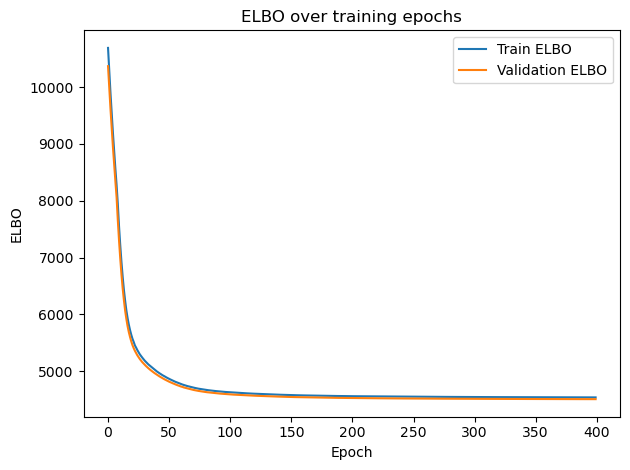

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy arrays
elbo_train = np.array(model.history["elbo_train"])
elbo_val = np.array(model.history["elbo_validation"])

# Last values
last_val_train = elbo_train[-1]
last_val_valid = elbo_val[-1]

# Global min/max
global_min_loss = min(elbo_train.min(), elbo_val.min())
global_max_loss = max(elbo_train.max(), elbo_val.max())
last_max_loss = max(last_val_train, last_val_valid)

# Plot
fig, ax = plt.subplots()
ax.plot(elbo_train, label="Train ELBO")
ax.plot(elbo_val, label="Validation ELBO")
ax.set(
    title="ELBO over training epochs",
    ylabel="ELBO",
    xlabel="Epoch",
)
ax.legend()
plt.tight_layout()
plt.show()



In [25]:
history = model.history

## Store Latent Space

In [9]:
CCVI_LATENT_KEY = "latent_space"

latent = model.get_latent_representation()
adata.obsm[CCVI_LATENT_KEY] = latent
latent.shape

(17192, 10)

## Visualize Latent Space

In [10]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0,0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print("Sorted Drug concentrations",adata.obs["drugconc_ordered"].unique())

[0.   0.05 0.5  5.  ]
Sorted Drug concentrations [0.00, 0.05, 0.50, 5.00]
Categories (4, float64): [0.00 < 0.05 < 0.50 < 5.00]


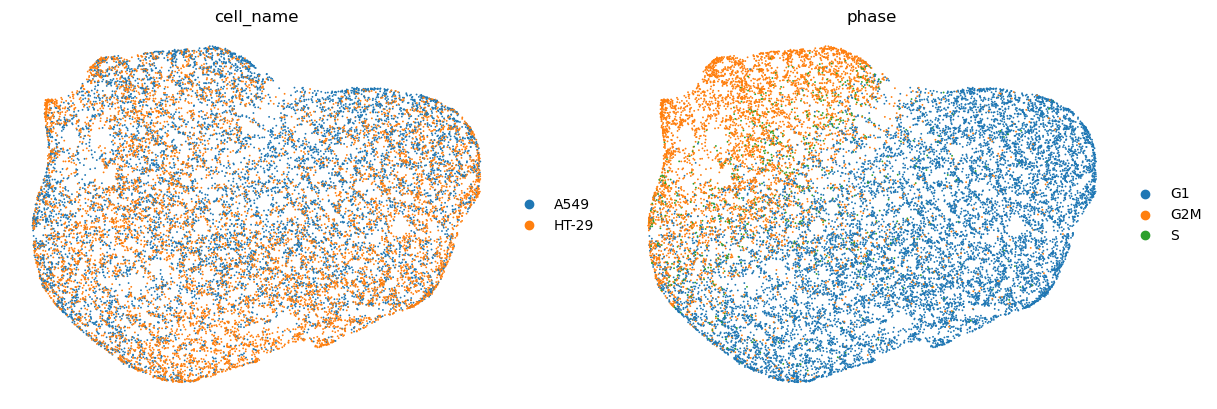

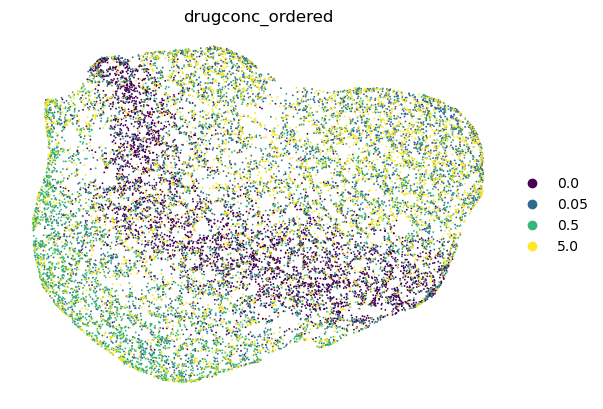

In [11]:
sc.pp.neighbors(adata, use_rep=CCVI_LATENT_KEY,n_neighbors=200)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_name","phase"],
    ncols = 2,
    frameon=False,
)

sc.pl.umap(
    adata,
    color=["drugconc_ordered"],
    frameon=False,
    palette="viridis"
)


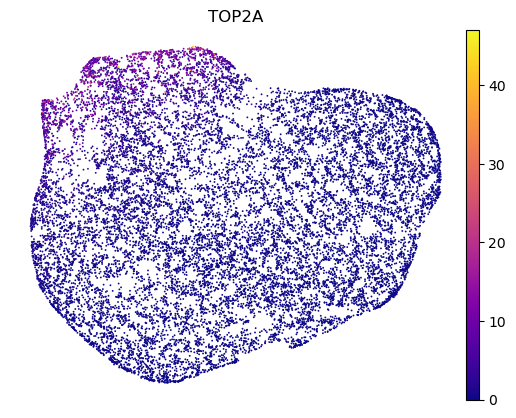

In [12]:
sc.pl.umap(
    adata,
    color=["TOP2A"],
    frameon=False,
    cmap="plasma",
    ncols = 2
)

In [23]:
print(torch.__version__)
print(torch.version.cuda)  # should print something like '11.8'

2.5.1
None


## Clustering

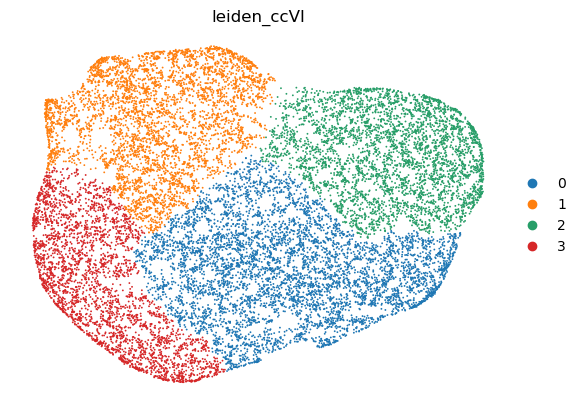

In [16]:
CCVI_CLUSTERS_KEY = "leiden_ccVI"
sc.tl.leiden(adata, key_added=CCVI_CLUSTERS_KEY, resolution=0.05)
sc.pl.umap(
    adata,
    color=[CCVI_CLUSTERS_KEY],
    frameon=False,
)

## Differential Gene Expression

In [40]:
de_df = model.differential_expression(adata,groupby=CCVI_CLUSTERS_KEY, mode="change")

markers = {}
clusters = adata.obs[CCVI_CLUSTERS_KEY].cat.categories

for cluster in clusters:
    cid = f"{cluster} vs Rest"
    df = de_df[de_df.comparison == cid]
    df = df[df["non_zeros_proportion1"] > 0.1]
    markers[cluster] = df.sort_values("bayes_factor", ascending=False).index[:3].tolist()


DE...:   0%|          | 0/4 [00:00<?, ?it/s]

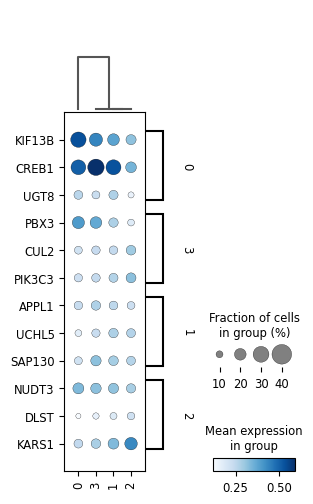

In [42]:
sc.tl.dendrogram(adata, groupby=CCVI_CLUSTERS_KEY, use_rep=CCVI_LATENT_KEY)

sc.pl.dotplot(
    adata,
    markers,
    groupby=CCVI_CLUSTERS_KEY,
    dendrogram=True,
    color_map="Blues",
    swap_axes=True
)


## Model Parameters

In [19]:
likelihood_params = model.get_likelihood_parameters(adata=adata, give_mean=True)
likelihood_params

{'mean': array([[6.6592409e-03, 5.1948428e-04, 8.8194154e-02, ..., 6.0036144e-04,
         8.1831554e-04, 3.1914236e-03],
        [1.7308740e-02, 1.3502468e-03, 2.2923480e-01, ..., 1.5604632e-03,
         2.1269710e-03, 8.2951691e-03],
        [8.3175711e-03, 6.4884988e-04, 1.1015687e-01, ..., 7.4986758e-04,
         1.0220982e-03, 3.9861742e-03],
        ...,
        [2.6119400e-02, 4.6779598e-05, 4.6143600e-01, ..., 1.7950213e-06,
         1.1232843e-03, 7.7947602e-03],
        [9.7142542e-03, 4.3231779e-05, 2.0256318e-01, ..., 4.2146039e-06,
         5.7198538e-04, 3.1758470e-03],
        [9.6945353e-03, 2.3559843e-04, 2.7540165e-01, ..., 1.3072496e-04,
         1.0256185e-03, 3.7570996e-03]], dtype=float32),
 'dispersions': array([[0.7306647 , 0.27727228, 1.3942245 , ..., 2.5393097 , 1.1493945 ,
         2.2961016 ],
        [0.7306647 , 0.27727228, 1.3942245 , ..., 2.5393097 , 1.1493945 ,
         2.2961016 ],
        [0.7306647 , 0.27727228, 1.3942245 , ..., 2.5393097 , 1.1493945

In [27]:
state_dict = model.module.state_dict()
state_dict

OrderedDict([('z_encoder.encoder.fc_layers.Layer 0.0.weight',
              tensor([[-0.0083,  0.0003, -0.0362,  ..., -0.0022, -0.0037, -0.0285],
                      [ 0.0012,  0.0016, -0.0206,  ...,  0.0029, -0.0065,  0.0207],
                      [-0.0134, -0.0008, -0.0097,  ...,  0.0005, -0.0037, -0.0033],
                      ...,
                      [ 0.0119, -0.0044, -0.0151,  ...,  0.0029,  0.0039, -0.0231],
                      [ 0.0039,  0.0049, -0.0141,  ..., -0.0039,  0.0015, -0.0204],
                      [ 0.0279, -0.0015, -0.0642,  ...,  0.0002,  0.0107,  0.0564]])),
             ('z_encoder.encoder.fc_layers.Layer 0.0.bias',
              tensor([ 3.8180e-03, -3.2111e-03,  3.1728e-03, -3.1787e-03,  1.9864e-03,
                       3.1792e-03,  3.4584e-03, -3.5959e-03,  2.9237e-03, -2.3420e-03,
                       4.6586e-04,  3.6526e-03, -2.7764e-03, -4.6668e-04, -1.0468e-03,
                      -5.5721e-04, -3.3955e-03,  2.7443e-03, -4.1783e-04,  3.3398e-

In [26]:
import pandas as pd

# Step 1: Extract and convert the weight tensor
W_drug_tensor = state_dict['decoder.W_drug']
W_drug = W_drug_tensor.cpu().detach().numpy().flatten()

# Step 2: Obtain gene names
gene_names = adata.var.index.tolist()

# Step 3: Create the DataFrame
W_drug_df = pd.DataFrame({'gene_name': gene_names, 'weight': W_drug})

# Step 4: Sort the DataFrame in descending order based on 'weight'
W_drug_df_sorted = W_drug_df.sort_values(by='weight', ascending=False)

# Display the sorted DataFrame
print(W_drug_df_sorted)


             gene_name    weight
18501        RN7SKP255  2.474977
51853  ENSG00000272872  1.787246
7548             DUOX1  1.783143
18996         RN7SKP71  1.769749
41216  ENSG00000253627  1.758468
...                ...       ...
28293           CT45A5 -3.894504
30135          IGBP1P3 -3.906649
29136            ME2P1 -4.022404
51809  ENSG00000272798 -4.061106
22454           PHB1P7 -4.083879

[62710 rows x 2 columns]


In [83]:

W_drug_df_sorted.loc[W_drug_df_sorted['gene_name'] == 'CCND1']

,gene_name,weight
3746,CCND1,0.636706


In [23]:
import pandas as pd

# Step 1: Extract and process W_cycle and the mask
W_cycle_tensor = state_dict['decoder.W_phase']
W_cycle = W_cycle_tensor.cpu().detach().numpy().T 

cycle_mask_tensor = state_dict['decoder.cycle_mask']
cycle_mask = cycle_mask_tensor.cpu().detach().numpy()
mask_bool = cycle_mask.astype(bool) 

W_cycle_masked = W_cycle[mask_bool]

gene_names = adata.var.index.tolist()
gene_names_masked = [gene for gene, keep in zip(gene_names, mask_bool) if keep]


W_cycle_df = pd.DataFrame(W_cycle_masked, index=gene_names_masked, columns=['a1', 'a2','a2'])


W_cycle_df_sorted = W_cycle_df.sort_values(by='a1', ascending=False)

print(W_cycle_df_sorted)


                 a1         a2         a2
NPM1      12.867502  14.002618  13.116927
HSP90AB1  11.927478  13.071009  12.001209
NUP58      8.497981  10.441412   9.151036
SET        7.366910   8.051861   7.957390
DHFR       7.150360   7.607893   7.616660
...             ...        ...        ...
CENPI     -3.193177  -1.488601   2.064268
H4C4      -3.266116   0.408165  -1.665066
HMMR      -3.283766  -0.965558   2.892543
BRCA2     -3.641123   0.022156   0.073992
TOP2A     -4.522684  -1.360424   1.750440

[693 rows x 3 columns]


In [25]:
genes = [ 'CCNA1', 'CCNB1','CCND1','CCNE1']
W_cycle_df_sorted.loc[W_cycle_df_sorted.index.isin(genes)]

,a1,a2,a3
CCND1,1.779769,1.000836,1.433751
CCNE1,1.005521,1.932405,1.503220
CCNB1,0.683833,1.011767,6.187869
CCNA1,-1.083733,-1.352340,-0.425761
